**TASK 0: LOAD CSV**

In [6]:
#importing necessary dependencies and libraries.
import numpy as np
import pandas as pd
import math
from collections import Counter

def load_data(filename):
    """Load CSV data into a pandas DataFrame"""
    return pd.read_csv(filename)

# Loading the datasets
training_data = load_data('UNSWNB15_training.csv')
testing1_data = load_data('UNSWNB15_testing1.csv')
testing2_data = load_data('UNSWNB15_testing2_no_label.csv')

# Display basic info about the datasets for initial exploration
print("Training data shape:", training_data.shape)
print("Testing1 data shape:", testing1_data.shape)
print("Testing2 data shape:", testing2_data.shape)
print("\nTraining data columns:", training_data.columns.tolist())

# Display the first two rows of training data
print("\nTraining data sample:")
print(training_data.head(2))

Training data shape: (20000, 44)
Testing1 data shape: (4000, 44)
Testing2 data shape: (25, 43)

Training data columns: ['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']

Training data sample:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000003  unas       -   INT      2      0     200       0   
1   2  0.885807   tcp     ftp   FIN     52     54    2934    3742   

            rate  ...  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0  333333.321500  ...                 4                 4             

**TASK 1: DATA PRE-PROCESSING**

In [3]:
def preprocess_data(data, is_training=True, cat_encoders=None, num_scalers=None):
    """
    Preprocess the data by:
    1. Encoding categorical variables (Label encoding)
    2. Scaling numerical features (min-max normalization)
    3. Separating features and labels (for training and testing1)
    """

    # Make a copy to avoid modifying original data
    processed = data.copy()

    # Identify categorical and numerical columns
    categorical_cols = ['proto', 'service', 'state']  # Given
    numerical_cols = [col for col in processed.columns
                     if col not in categorical_cols + ['label']
                     and processed[col].dtype in ['int64', 'float64']]

    # 1. Encode categorical variables (label encoding)
    if is_training:
        # For training data, create encoders
        cat_encoders = {}  # Stores mappings for proto/service/state
        for col in categorical_cols:
           # Assign unique integers to each category (e.g., 'tcp':0, 'udp':1)
            categories = processed[col].unique()
            cat_encoders[col] = {cat: i for i, cat in enumerate(categories)}

        # Apply encoding
        for col in categorical_cols:
            processed[col] = processed[col].map(cat_encoders[col])
    else:
        # For test data, use existing encoders
        for col in categorical_cols:
            # Map known categories, assign -1 to unknown categories (shouldn't happen with proper train/test split)
            processed[col] = processed[col].apply(lambda x: cat_encoders[col].get(x, -1))

    # 2. Scale numerical features
    if is_training:
        # For training data, compute min and max
        num_scalers = {}
        for col in numerical_cols:
            min_val = processed[col].min()
            max_val = processed[col].max()
            num_scalers[col] = {'min': min_val, 'max': max_val}
            # Avoid division by zero in case max == min
            if max_val != min_val:
                processed[col] = (processed[col] - min_val) / (max_val - min_val)
            else:
                processed[col] = 0  # Handle constant features
    else:
        # For test data, use existing scalers
        for col in numerical_cols:
            min_val = num_scalers[col]['min']
            max_val = num_scalers[col]['max']
            if max_val != min_val:
                processed[col] = (processed[col] - min_val) / (max_val - min_val)
            else:
                processed[col] = 0

    # 3. Separate features and labels if labels exist
    if 'label' in processed.columns:
        X = processed.drop('label', axis=1).values
        y = processed['label'].values
        return X, y, cat_encoders, num_scalers
    else:
        X = processed.values
        return X, None, cat_encoders, num_scalers

# Preprocess training data
X_train, y_train, cat_encoders, num_scalers = preprocess_data(training_data, is_training=True)

# Preprocess testing1 data
X_test1, y_test1, _, _ = preprocess_data(testing1_data, is_training=False,
                                        cat_encoders=cat_encoders, num_scalers=num_scalers)

# Preprocess testing2 data
X_test2, _, _, _ = preprocess_data(testing2_data, is_training=False,
                                 cat_encoders=cat_encoders, num_scalers=num_scalers)

print("\nPreprocessing complete.")
print("Training data shape after preprocessing:", X_train.shape)
print("Testing1 data shape after preprocessing:", X_test1.shape)
print("Testing2 data shape after preprocessing:", X_test2.shape)


Preprocessing complete.
Training data shape after preprocessing: (20000, 43)
Testing1 data shape after preprocessing: (4000, 43)
Testing2 data shape after preprocessing: (25, 43)


**TASK2: MODEL IMPLEMENTATION AND TRAINING**


Training MLP...
Epoch 0, Loss: 0.9114
Epoch 10, Loss: 1.1037
Epoch 20, Loss: 1.2274
Epoch 30, Loss: 1.3229
Epoch 40, Loss: 1.4177
Epoch 49, Loss: 1.5052


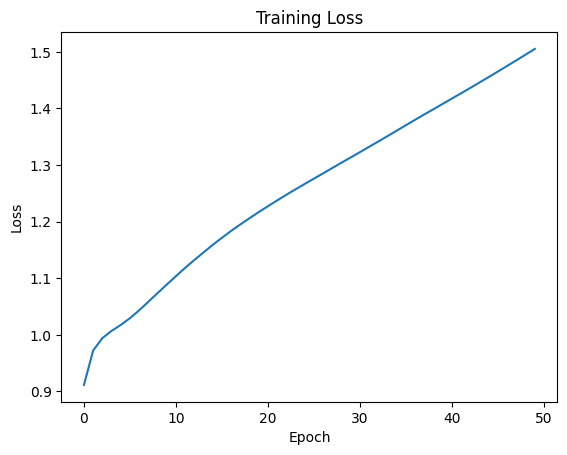

In [4]:
class MLP:
    """Implementation of a Multi-Layer Perceptron from scratch"""

    def __init__(self, input_size, hidden_sizes, output_size):
        """Initialize weights and biases"""
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.weights = []
        self.biases = []

        # Initialize weights with He initialization and biases to zeros
        for i in range(len(self.layer_sizes)-1):
            # He initialization: scale by sqrt(2/n) where n is input size
            scale = np.sqrt(2.0 / self.layer_sizes[i])   # layer_sizes[i] = input dimension
            self.weights.append(np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1]) * scale)
            self.biases.append(np.zeros((1, self.layer_sizes[i+1])))

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)

    def relu(self, x):
        """ReLU activation function"""
        return np.maximum(0, x)

    def relu_derivative(self, x):
        """Derivative of ReLU function"""
        return (x > 0).astype(float)

    def forward(self, x):
        """Forward pass through the network"""
        self.activations = [x]
        self.z_values = []

        # Hidden layers (use ReLU)
        for i in range(len(self.weights)-1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            self.activations.append(self.relu(z))

        # Output layer (use sigmoid for binary classification)
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        self.activations.append(self.sigmoid(z))

        return self.activations[-1]

    def backward(self, x, y, learning_rate):
        """Backward pass (backpropagation)"""
        m = x.shape[0]  # number of samples

        # Calculate output error
        error = self.activations[-1] - y.reshape(-1, 1)
        dZ = error * self.sigmoid_derivative(self.activations[-1])

        # Initialize lists to store gradients
        dW = [None] * len(self.weights)
        db = [None] * len(self.biases)

        # Gradient for output layer
        dW[-1] = np.dot(self.activations[-2].T, dZ) / m
        db[-1] = np.sum(dZ, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for l in range(len(self.weights)-2, -1, -1):     # Reverse order (output to input)
            dA = np.dot(dZ, self.weights[l+1].T)         # Error from next layer
            dZ = dA * self.relu_derivative(self.activations[l+1])   # Apply ReLU gradient
            dW[l] = np.dot(self.activations[l].T, dZ) / m
            db[l] = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases
        for l in range(len(self.weights)):
            self.weights[l] -= learning_rate * dW[l]
            self.biases[l] -= learning_rate * db[l]

    def train(self, X, y, epochs, learning_rate, batch_size=32, verbose=True):
        """Train the MLP"""
        losses = []
        for epoch in range(epochs):
            # Mini-batch training
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward and backward pass
                self.forward(X_batch)
                self.backward(X_batch, y_batch, learning_rate)

            # Calculate loss for the entire dataset
            y_pred = self.forward(X)
            loss = self.binary_cross_entropy(y, y_pred)
            losses.append(loss)

            if verbose and (epoch % 10 == 0 or epoch == epochs-1):
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

        return losses

    def binary_cross_entropy(self, y_true, y_pred):
        """Calculate binary cross-entropy loss"""
        epsilon = 1e-15  # to avoid log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def predict(self, X, threshold=0.5):
        """Make predictions"""
        y_prob = self.forward(X)
        return (y_prob > threshold).astype(int)

    def evaluate(self, X, y):
        """Evaluate model performance"""
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred.flatten() == y)
        return accuracy

# Initialize and train the MLP
input_size = X_train.shape[1]
hidden_sizes = [64, 32]  # Two hidden layers
output_size = 1

mlp = MLP(input_size, hidden_sizes, output_size)

print("\nTraining MLP...")
losses = mlp.train(X_train, y_train, epochs=50, learning_rate=0.01, batch_size=64)

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

**TASK 3: MODEL PERFORMANCE EVALUATION**

In [5]:
def calculate_metrics(y_true, y_pred):
    """Calculate various performance metrics"""
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': np.array([[tn, fp], [fn, tp]])
    }

# Evaluate on testing set 1
y_pred_test1 = mlp.predict(X_test1).flatten()
metrics = calculate_metrics(y_test1, y_pred_test1)

print("\nPerformance on Testing Set 1:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print("Confusion Matrix:")
print(metrics['confusion_matrix'])

# Predict labels for testing set 2
y_pred_test2 = mlp.predict(X_test2).flatten()

print("\nPredictions for Testing Set 2:")
print(y_pred_test2)



Performance on Testing Set 1:
Accuracy: 0.8880
Precision: 0.9640
Recall: 0.8659
F1 Score: 0.9123
Confusion Matrix:
[[1221   87]
 [ 361 2331]]

Predictions for Testing Set 2:
[1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1]
